# Web Scraping and Introductory Data Analysis
bla bla bla

## Part 1: Web Scraping 

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


In [3]:
WEB_URL = "https://etherscan.io/txs"
TRX_TABLE_XPATH_HEAD = "//table[@class='table table-hover table-align-middle mb-0']/thead/tr/th"
TRX_TABLE_XPATH_BODY = "//table[@class='table table-hover table-align-middle mb-0']/tbody/tr"
ETHER_SCAN_CSV_FILE = "etherscan.csv"
NUM_OF_BLOCKS = 10


We begin by initializing a WebDriver using Selenium. Specifically, we use the Firefox WebDriver to instantiate a Firefox browser instance. This WebDriver will facilitate interactions with web elements. The WebDriver navigates to the [Etherscan.io](https://etherscan.io/txs).  
An assertion is used to verify that the title of the webpage contains the keyword "Ethereum". This step ensures that the WebDriver successfully loaded the expected webpage.  
Also it is good to mention that the webdriver will wait for a page to load by default via .get() method before attempting to scrape the data.

In [4]:
driver = webdriver.Firefox()
def setupWebDriver():
    driver.get(WEB_URL)
    assert "Ethereum" in driver.title

setupWebDriver()

The getTrxTableHeaders function extracts transactions table headers from HTML source code using the table's id. It modifies the extracted headers to match a specific format and returns the modified header as a list.  
The getTrxTableBody function extracts the body of a transaction table from HTML source code using Beautiful Soup. It iterates through each row of the table, extracts the text from each cell, removes newline characters. Additionally, it captures the block number from the first row of the table. 

In [5]:
def getTrxTableHeaders(html_src):
    trx_table_head = html_src.find(id = "ContentPlaceHolder1_theadAllTransactionTable").find_all('th')
    header = [header.get_text().replace("\n", "") for header in trx_table_head]
    header[2] = "Method"
    header.pop(0)
    header.pop(5)
    header.insert(3, "Date")
    header.insert(5, "Local Time")
    header.append("Gas Price")
    return header

def getTrxTableBody(rows_elements, html_src):
    trx_table_body = html_src.find('table')
    trx_table_body = trx_table_body.find_all('tr')
    block_number = 0
    for i in range(1, len(trx_table_body)):
        rows = trx_table_body[i].find_all('td')
        element = [elem.get_text() for elem in rows]
        element = list(map(lambda x: x.replace("\n", ""), element))
        element.pop(8)
        element.pop(0)
        if i == 1:
            block_number = int(element[2])
        rows_elements.append(element)
    return rows_elements, block_number

In this part we iterate through the transaction table, continuously fetching data until a certain condition is met. We click on the "Next" button in order to implement pagination handling to navigate through the pages and collect the last 10 blocks' transactions data. In this case that certain condition is the block number; At each iteration we get the first row's block number and compare it to the latest block number that we have.  
In the end we save the data into a DataFrame.

In [6]:
def saveTransactionsToDp(header, body):
    transactionsDf = pd.DataFrame(body, columns=header)
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, mode='a', header=False, index=False)
    return transactionsDf
    
def scrapeWebPage():
    html_src = BeautifulSoup(driver.page_source, 'html.parser')
    header = getTrxTableHeaders(html_src)
    rows_elements = []
    body, latest_block_number = getTrxTableBody(rows_elements, html_src)
    while True:
        html_src = BeautifulSoup(driver.page_source, 'html.parser')
        body, block_number = getTrxTableBody(body, html_src)
        next_button = driver.find_element(By.XPATH, '//a[@aria-label="Next"]')
        next_button.click()
        if block_number == latest_block_number - NUM_OF_BLOCKS:
            break
    transactionsDf = saveTransactionsToDp(header, body)
    driver.close()
    return latest_block_number, transactionsDf


In [7]:
latest_block_number, transactionsDf = scrapeWebPage()
def saveToCsvFile(transactionsDf):
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, index=False)
    
saveToCsvFile(transactionsDf)

## Part 2: Data Analysis

#### Clean Transactions Data

In [8]:
transactionsDf_raw = transactionsDf.copy()

In [9]:
display(transactionsDf)

,Txn Hash,Method,Block,Date,Age,Local Time,From,To,Value,Txn Fee,Gas Price
0,0x33fcda45305b6397e26f0e5b93d881ded390c70d986d...,Transfer,19395512,2024-03-09 5:40:11,11 secs ago,1709962811,beaverbuild,0xD6E4aA93...da06F9cEf,0.054042147 ETH,0.00113123,40.17330149
1,0xd18ba3a0862d38e07e0569f6fc87ac8941718c4f9ee1...,Withdraw,19395512,2024-03-09 5:40:11,11 secs ago,1709962811,0x9D6C469E...30f6D32e5,0xC2966A73...E972eD89e,0 ETH,0.00327707,40.22330149
2,0xde647fa6bd3447b1a79d695e5e048cd9aa397c444d62...,Unoswap,19395512,2024-03-09 5:40:11,11 secs ago,1709962811,0x4e590cEE...940f96d4d,1inch v5: Aggregation Router,0 ETH,0.00636674,40.22330149
3,0x89a8e13c2abd3fdd5e6fe1834ee47ce9d8fbc851b0c9...,Multicall,19395512,2024-03-09 5:40:11,11 secs ago,1709962811,utgl.eth,Uniswap V3: Positions NFT,0 ETH,0.00703802,40.26330149
4,0xc0445d25c8f2d49e03f8e53c46abbd175867552a407b...,Transfer,19395512,2024-03-09 5:40:11,11 secs ago,1709962811,0xe9c9d7F2...7F901f14b,Tether: USDT Stablecoin,0 ETH,0.00254451,40.26330149
...,...,...,...,...,...,...,...,...,...,...,...
2345,0x53c64563a91b52b53e0145bbdaefd4585acc33a82aa5...,Transfer,19395502,2024-03-09 5:38:11,3 mins ago,1709962691,0x9090877D...D594dd9cD,0xF39ecb5E...8e29cBD73,0 ETH,0.000903,43
2346,0x17c61b8e3b07d0915de8ed74feb8d81eeaf9b1b81cac...,Transfer,19395502,2024-03-09 5:38:11,3 mins ago,1709962691,0x15B789aB...B555635d0,0xC8dCee2F...082c718F3,0 ETH,0.000903,43
2347,0xa11cfccc35158b39c38009668121265d5488306d0d8a...,Transfer,19395502,2024-03-09 5:38:11,3 mins ago,1709962691,Coinbase 5,0x9cA34Ed1...429801e30,0.01170274 ETH,0.00091728,43.68026755
2348,0x9a250be2fbf3701b70274b2bd6ede2bd5bac843422b4...,Transfer,19395502,2024-03-09 5:38:11,3 mins ago,1709962691,Coinbase 14,0x689A64a8...6a13ea199,0.00239424 ETH,0.00091728,43.68026755


In [10]:
transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Txn Hash    2350 non-null   object
 1   Method      2350 non-null   object
 2   Block       2350 non-null   object
 3   Date        2350 non-null   object
 4   Age         2350 non-null   object
 5   Local Time  2350 non-null   object
 6   From        2350 non-null   object
 7   To          2350 non-null   object
 8   Value       2350 non-null   object
 9   Txn Fee     2350 non-null   object
 10  Gas Price   2350 non-null   object
dtypes: object(11)
memory usage: 202.1+ KB


In [11]:
print(f"Rows count before removing duplicate rows: {transactionsDf.shape[0]}")
transactionsDf.drop_duplicates(subset=['Txn Hash'], inplace=True)
print(f"Rows count after removing duplicate rows: {transactionsDf.shape[0]}")

transactionsDf_removed_dups = transactionsDf.copy()

Rows count before removing duplicate rows: 2350
Rows count after removing duplicate rows: 1540


In [12]:
transactionsDf.drop(columns=['Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price'], inplace=True)

transactionsDf['Block'] = transactionsDf['Block'].astype(int)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].astype(float)
transactionsDf['Value'] = transactionsDf['Value'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Value'] = transactionsDf['Value'].apply(lambda x: float(x.split(' ')[0]) if 'ETH' in x else float(x.split(' ')[0])/10**18)

transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 2349
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  1540 non-null   object 
 1   Method    1540 non-null   object 
 2   Block     1540 non-null   int32  
 3   Value     1540 non-null   float64
 4   Txn Fee   1540 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 66.2+ KB


In [13]:
print("Before removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

block_mask = (transactionsDf['Block'] > latest_block_number - NUM_OF_BLOCKS) & (transactionsDf['Block'] <= latest_block_number)
transactionsDf = transactionsDf[block_mask]

print("\nAfter removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

Before removing Extra Blocks:
Max Block number: 19395512, Min Block number:  19395502
Unique Values in Block Column: 11

After removing Extra Blocks:
Max Block number: 19395512, Min Block number:  19395503
Unique Values in Block Column: 10


In [14]:
transactionsDf_cleansed = transactionsDf.copy()

In [15]:
transactionsDf_with_zero_txn = transactionsDf.copy()
display(transactionsDf_with_zero_txn.describe())

transactionsDf_without_zero_txn = transactionsDf[transactionsDf['Value'] > 0]
display(transactionsDf_without_zero_txn.describe())

,Block,Value,Txn Fee
count,1.442000e+03,1442.000000,1442.000000
mean,1.939551e+07,0.472326,0.004253
std,2.728177e+00,5.117113,0.008210
min,1.939550e+07,0.000000,0.000792
25%,1.939550e+07,0.000000,0.000929
50%,1.939551e+07,0.000000,0.002055
75%,1.939551e+07,0.038176,0.005629
max,1.939551e+07,130.581950,0.203204


,Block,Value,Txn Fee
count,6.860000e+02,6.860000e+02,686.000000
mean,1.939551e+07,9.928479e-01,0.003346
std,2.760699e+00,7.386893e+00,0.008795
min,1.939550e+07,1.000000e-17,0.000792
25%,1.939550e+07,1.032040e-02,0.000871
50%,1.939551e+07,4.759697e-02,0.000916
75%,1.939551e+07,2.000000e-01,0.005165
max,1.939551e+07,1.305820e+02,0.203204


### Plotting Histogram of Tnx Fee and Value with and without zero transactions

Transaction Fee Distribution

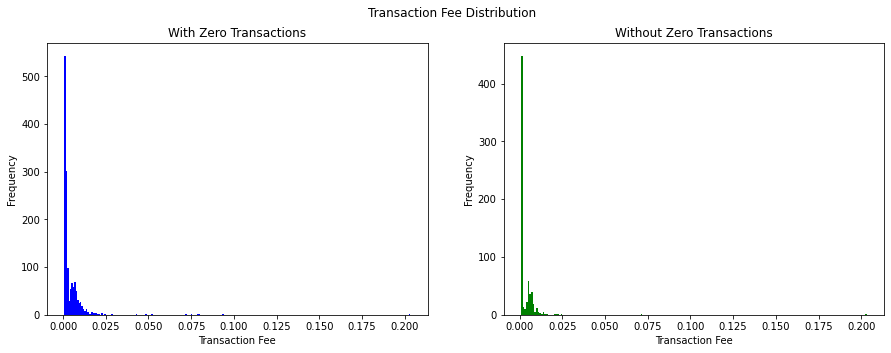

In [16]:
# 3.5 * standard deviation * n^(-1/3)
# bin_width_with_zero_txn = (3.5 * transactionsDf_with_zero_txn['Txn Fee'].std()) / (transactionsDf_with_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)

# bin_width_without_zero_txn = (3.5 * transactionsDf_without_zero_txn['Txn Fee'].std()) / (transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

# #square root of the number of transactions
# bin_size_with_zero_txn = int(transactionsDf_with_zero_txn['Txn Fee'].count()** (1/2))
# bin_size_without_zero_txn = int(transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/2))

# 2 * IQR * n^(-1/3)
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()


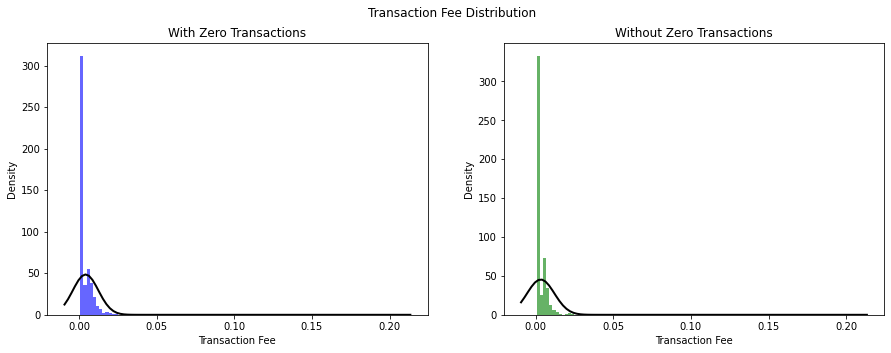

In [37]:

# 1 + log2(n) is the optimal number of bins
# bin_size_with_zero_txn = 1 + int(np.log2(transactionsDf_with_zero_txn['Txn Fee'].count()))
# bin_size_without_zero_txn = 1 + int(np.log2(transactionsDf_without_zero_txn['Txn Fee'].count()))

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle('Transaction Fee Distribution')

# ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
# ax[0].set_title('With Zero Transactions')
# ax[0].set_xlabel('Transaction Fee')
# ax[0].set_ylabel('Frequency')

# ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
# ax[1].set_title('Without Zero Transactions')
# ax[1].set_xlabel('Transaction Fee')
# ax[1].set_ylabel('Frequency')

# plt.show()

# 1 + log2(n) is the optimal number of bins
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

if bin_size_with_zero_txn > 50:
    bin_size_with_zero_txn = 100
if bin_size_without_zero_txn > 50:
    bin_size_without_zero_txn = 100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(transactionsDf_with_zero_txn['Txn Fee'])
mu2, std2 = norm.fit(transactionsDf_without_zero_txn['Txn Fee'])

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

plt.show()

#### Plotting the Histogram of transaction fee using log transformation

In [61]:
def calcBinSize(df):
    bin_width = 2 * (df.quantile(0.75) - df.quantile(0.25)) * df.count() ** (-1/3)
    bin_size = round((df.max() - df.min()) / bin_width)
    if bin_size > 50:
        bin_size = 100
    return bin_size

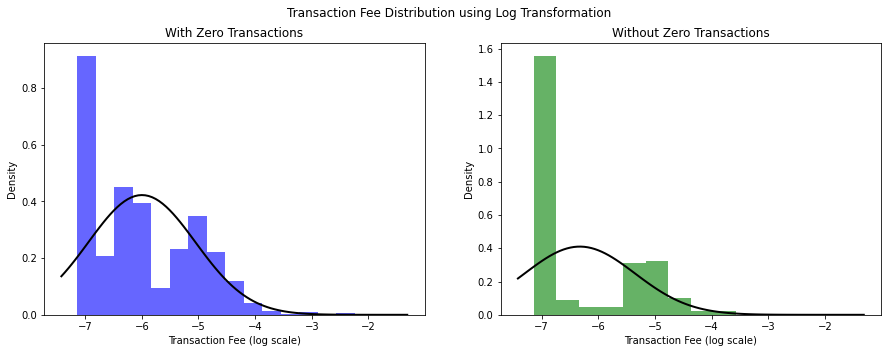

In [65]:
bin_size_with_zero_txn = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Txn Fee']))
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Txn Fee']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(transactionsDf_with_zero_txn['Txn Fee']))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Txn Fee']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee (log scale)')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee (log scale)')
ax[1].set_ylabel('Density')

plt.show()

Transaction Value Distribution

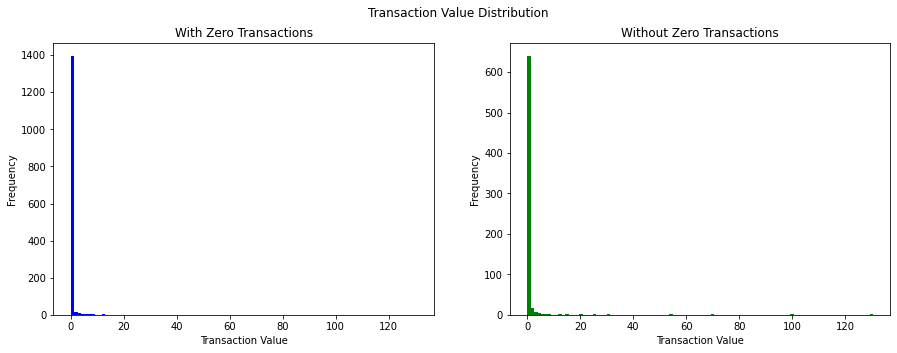

In [73]:

bin_size_with_zero_txn = calcBinSize(transactionsDf_with_zero_txn['Value'])
bin_size_without_zero_txn = calcBinSize(transactionsDf_without_zero_txn['Value'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Value'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Value'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Frequency')

plt.show()

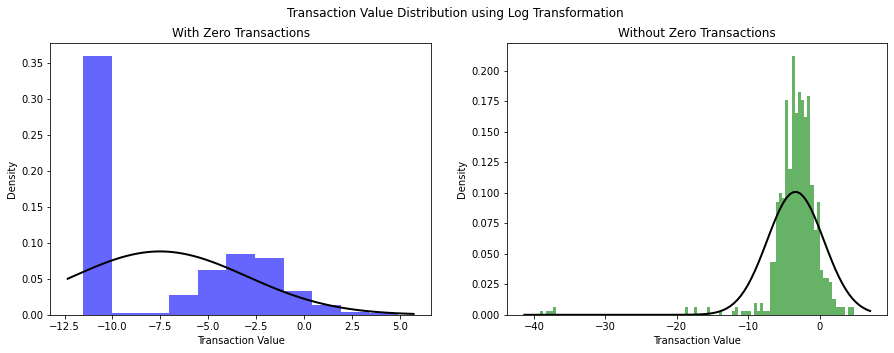

In [81]:
epsilon = 1e-5
tnx_with_epsilon_as_zero = transactionsDf_with_zero_txn['Value'] + epsilon
bin_size_with_zero_txn = calcBinSize(np.log(tnx_with_epsilon_as_zero))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Value']))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

ax[0].hist(np.log(tnx_with_epsilon_as_zero), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Value']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(tnx_with_epsilon_as_zero))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Value']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

plt.show()

### Box Plot

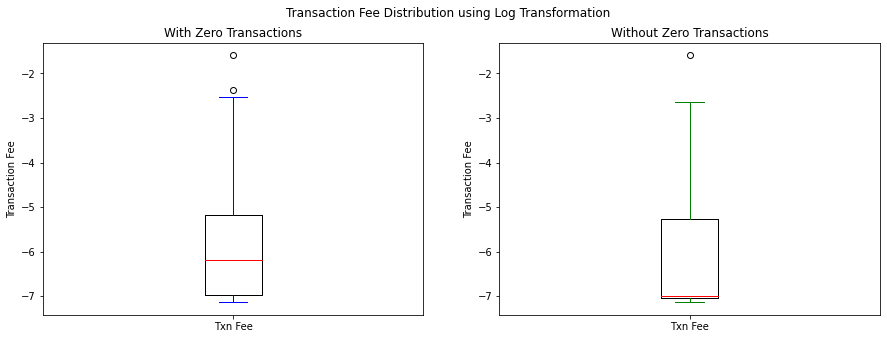

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Txn Fee'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Txn Fee']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Txn Fee'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

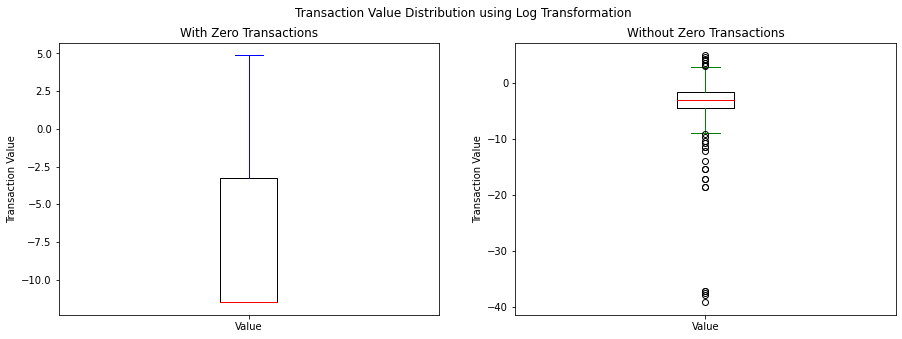

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(tnx_with_epsilon_as_zero))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Value']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

### Violin Plot

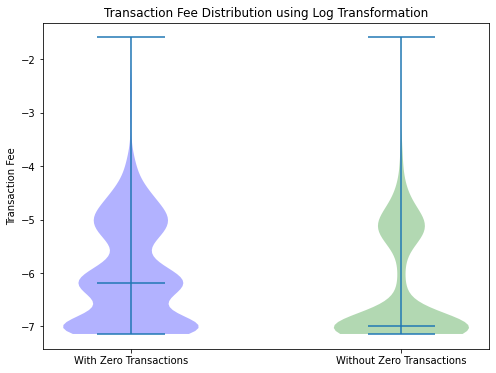

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(transactionsDf_without_zero_txn['Txn Fee'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()


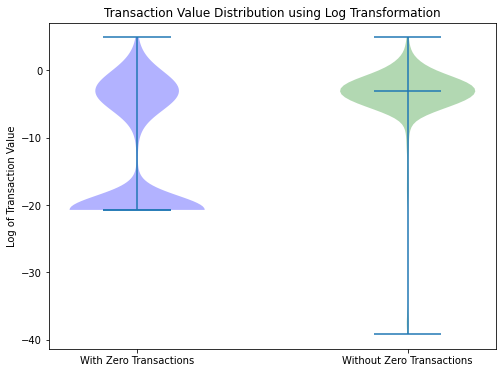

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(tnx_with_epsilon_as_zero), np.log(transactionsDf_without_zero_txn['Value'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

## Sampling Data

### Simple Random Sampling (SRS) 

In [47]:
sampled_with_simple_random = transactionsDf_without_zero_txn.sample(n=int(0.1 * transactionsDf_without_zero_txn.shape[0]))
display(sampled_with_simple_random.describe())

,Block,Value,Txn Fee
count,6.800000e+01,6.800000e+01,68.000000
mean,1.939551e+07,1.333953e+00,0.005578
std,2.554584e+00,8.473926e+00,0.024496
min,1.939550e+07,1.000000e-17,0.000798
25%,1.939551e+07,1.038882e-02,0.000878
50%,1.939551e+07,7.252726e-02,0.000913
75%,1.939551e+07,2.308632e-01,0.005126
max,1.939551e+07,7.000000e+01,0.203204


In [52]:
transactionsDf_without_zero_txn.describe()

,Block,Value,Txn Fee
count,6.860000e+02,6.860000e+02,686.000000
mean,1.939551e+07,9.928479e-01,0.003346
std,2.760699e+00,7.386893e+00,0.008795
min,1.939550e+07,1.000000e-17,0.000792
25%,1.939550e+07,1.032040e-02,0.000871
50%,1.939551e+07,4.759697e-02,0.000916
75%,1.939551e+07,2.000000e-01,0.005165
max,1.939551e+07,1.305820e+02,0.203204


In [54]:
sample_proportion = 0.1 
sampled_with_stratified = pd.DataFrame()

for method, group in transactionsDf_without_zero_txn.groupby('Method'):
    num_samples = int(len(group) * sample_proportion)
    sampled_group = group.sample(n=num_samples, random_state=42)
    sampled_with_stratified = pd.concat([sampled_with_stratified, sampled_group])

sampled_with_stratified.describe()
# transactionsDf_without_zero_txn_describe = transactionsDf_without_zero_txn.describe()
# descriptions = pd.concat([sampled_with_stratified_describe, transactionsDf_without_zero_txn_describe], axis=1)
# display(descriptions)

,Block,Value,Txn Fee
count,5.300000e+01,53.000000,53.000000
mean,1.939551e+07,1.365715,0.001820
std,3.073483e+00,7.527961,0.002082
min,1.939550e+07,0.000010,0.000823
25%,1.939550e+07,0.006499,0.000863
50%,1.939551e+07,0.022762,0.000892
75%,1.939551e+07,0.130000,0.000959
max,1.939551e+07,54.491000,0.008262


In [ ]:
# def compute_subgroup_stats(df):
#     numeric_cols = df.select_dtypes(include='number')
#     subgroup_stats = {}
#     subgroup_stats['Mean'] = numeric_cols.mean()
#     subgroup_stats['Median'] = numeric_cols.median()
#     # Add more statistics as needed
#     return pd.DataFrame(subgroup_stats)

# # Assuming df_original and df_sampled are your original and sampled DataFrames, respectively
# # and subgroup_cols contains the columns to group by

# original_subgroup_stats = compute_subgroup_stats(transactionsDf_without_zero_txn)
# stratified_sampled_subgroup_stats = compute_subgroup_stats(sampled_with_stratified)
# simple_sampled_subgroup_stats = compute_subgroup_stats(sampled_with_simple_random)
# # Concatenate the subgroup statistics horizontally with custom column names
# subgroup_descriptions = pd.concat([original_subgroup_stats, stratified_sampled_subgroup_stats, sampled_with_simple_random], axis=1)
# subgroup_descriptions.columns = pd.MultiIndex.from_product([['Original', 'Stratified Sample', 'Simple Sample'], original_subgroup_stats.columns])

# print(subgroup_descriptions)

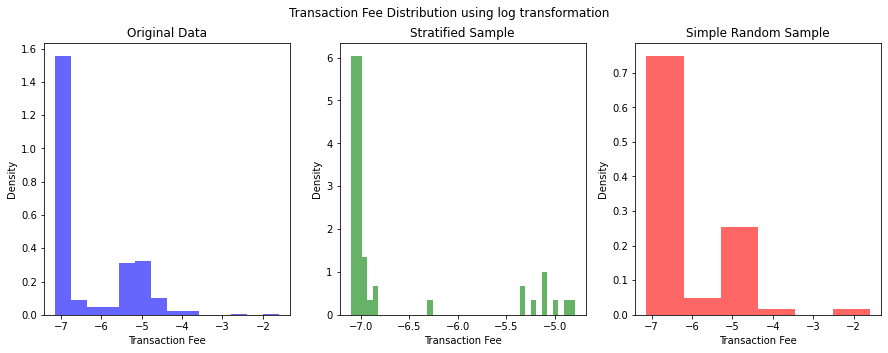

In [66]:
bin_size_original = calcBinSize(np.log(transactionsDf_without_zero_txn['Txn Fee']))
bin_size_stratified = calcBinSize(np.log(sampled_with_stratified['Txn Fee']))
bin_size_simple = calcBinSize(np.log(sampled_with_simple_random['Txn Fee']))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_without_zero_txn['Txn Fee']), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(sampled_with_stratified['Txn Fee']), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(sampled_with_simple_random['Txn Fee']), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Fee')
ax[2].set_ylabel('Density')

plt.show()

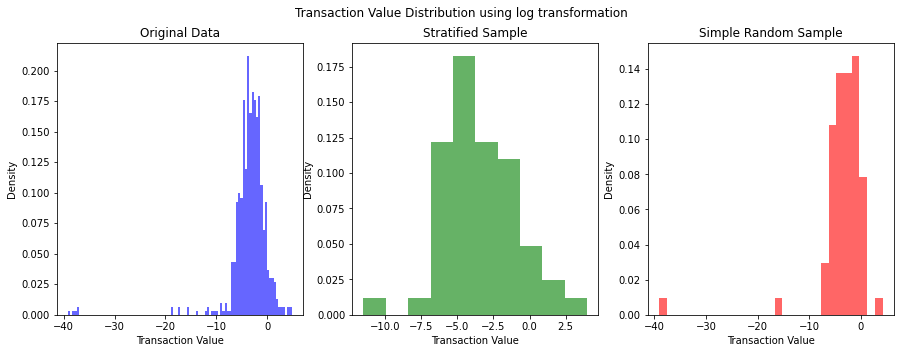

In [69]:
bin_size_original = calcBinSize(np.log(transactionsDf_without_zero_txn['Value']))
bin_size_stratified = calcBinSize(np.log(sampled_with_stratified['Value']))
bin_size_simple = calcBinSize(np.log(sampled_with_simple_random['Value']))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_without_zero_txn['Value']), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(sampled_with_stratified['Value']), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(sampled_with_simple_random['Value']), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Value')
ax[2].set_ylabel('Density')

plt.show()

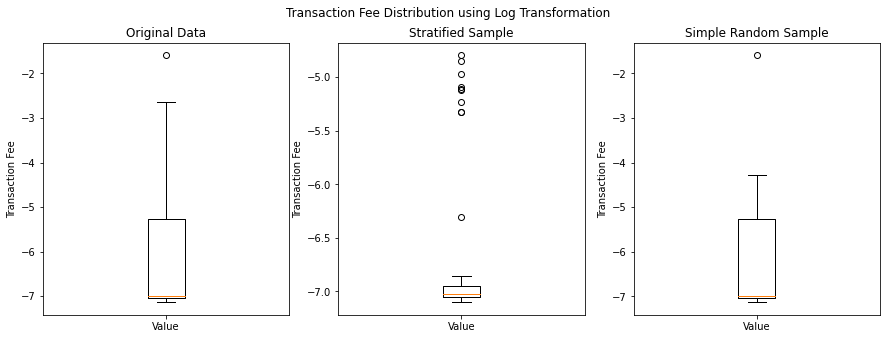

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_without_zero_txn['Txn Fee']))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(sampled_with_stratified['Txn Fee']))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(sampled_with_simple_random['Txn Fee']))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Fee')
ax[2].set_xticklabels(['Value'])

plt.show()

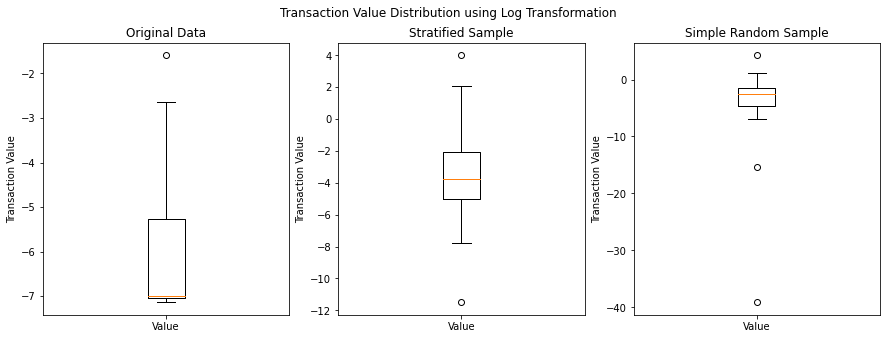

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_without_zero_txn['Value']))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(sampled_with_stratified['Value']))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(sampled_with_simple_random['Value']))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Value')
ax[2].set_xticklabels(['Value'])

plt.show()



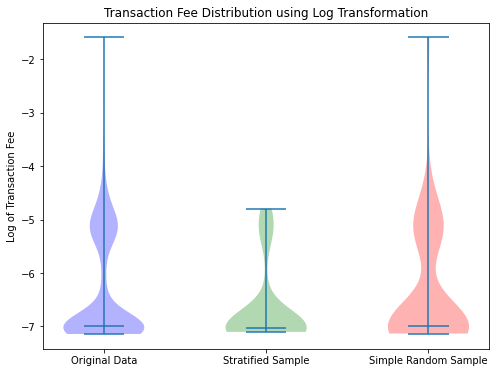

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_without_zero_txn['Txn Fee']), np.log(sampled_with_stratified['Txn Fee']), np.log(sampled_with_simple_random['Txn Fee'])], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

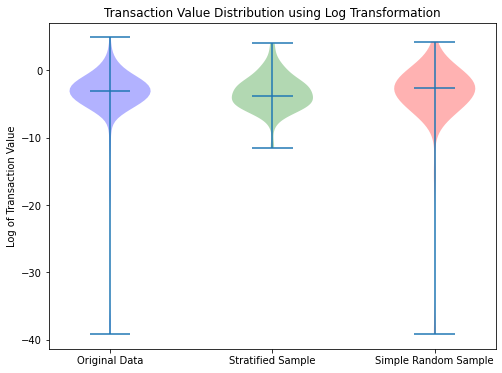

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_without_zero_txn['Value']), np.log(sampled_with_stratified['Value']), np.log(sampled_with_simple_random['Value'])], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()